### Суть исследования заключается в том, чтобы найти человека по фото ВК, используя вектор средних значений кол-ва пикселей каждого цвета на изображении.

In [1]:
import vk_api
import os
from scipy.misc import imread
import numpy as np

In [2]:
vk_session = vk_api.VkApi(token=os.environ.get('TOKEN'))

In [3]:
vk = vk_session.get_api()
tools = vk_api.VkTools(vk_session)

In [6]:
x = []
for img_path in os.listdir("nadya_photos")[1:]:
    x.append(imread("nadya_photos/" + img_path))
x = np.array(x)

In [7]:
def img2vec(img):
    return np.array([img[:, :, 0].mean() / 255, img[:, :, 1].mean() / 255, img[:, :, 2].mean() / 255])

In [8]:
nadya_vectors = np.array([img2vec(img) for img in x])

#### Получившиеся векторы фото

In [9]:
nadya_vectors

array([[ 0.49227204,  0.40338067,  0.37965704],
       [ 0.34509697,  0.28770448,  0.30109494],
       [ 0.63049107,  0.43697823,  0.36774123],
       [ 0.55369651,  0.59933573,  0.55782658],
       [ 0.55357394,  0.44108207,  0.43716866],
       [ 0.63346357,  0.57174158,  0.51666911],
       [ 0.52248166,  0.43947576,  0.44532213],
       [ 0.71007449,  0.60307565,  0.57566663]])

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
import requests
from io import BytesIO
from PIL import Image

### Ищем определенный круг людей, по которым осуществим поиск

In [12]:
s = vk.users.search(q="Надежда", city=2, university=1, sex=1, age_from=18, age_to=19, count=1000, fields="photo_max")

### Смотрим аватарку каждого пользователя, скачиваем картинку и представляем в виде вектора. Создаем словарь, в котором матчим id с максимальным косинусом угла между имеющимися векторами и аватаркой.

In [39]:
import tqdm
d = {}
for user in s['items']:
    try:
        url = user['photo_max']
        r = requests.get(url)

        img = Image.open(BytesIO(r.content))
        img = np.array(img.getdata())
        vec = np.array([img[:, 0].mean() / 255, img[:, 1].mean() / 255, img[:, 2].mean() / 255])
        syms = [cosine_similarity([vec], [nadya_vec])[0][0] for nadya_vec in nadya_vectors]
#         print(user['id'], syms, end='\n\n')
        d[user['id']] = np.max(syms)
    except Exception as e: print(e)

too many indices for array
too many indices for array


In [43]:
# Первые 5 и последние 5 результатов
t = sorted(d.items(), key=lambda x: x[1], reverse=True)
t[:5] + t[-5:]

[(219634013, 0.99999169984195124),
 (67005932, 0.99990229973047784),
 (271835049, 0.99989729256177229),
 (17033844, 0.9998900363605675),
 (64507882, 0.99979981624752634),
 (67745159, 0.99408030578290951),
 (227141768, 0.99015502923747367),
 (114627928, 0.98811554995145467),
 (210785751, 0.97381761006504797),
 (208597793, 0.93132760285525462)]

### Фото с чем сравнивали и фото из ВК

<img src="http://i.imgur.com/5Vseso8.png" align="left" style="width: 200px;"/>

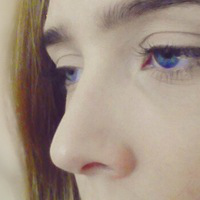

In [49]:
Image.open(BytesIO(requests.get("https://pp.userapi.com/c837336/v837336013/5a19b/9H3Kjdk9IAs.jpg").content))

## Заключение: С помощью простейших методов линейной алгебры можно установить соответствие между двумя очень похожими фото, даже если они были изменены в размере, обрезаны, наложены логотипы и т.д.